In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# Path to the directory containing pickle files
dir_path = '/storage/vbutoi/scratch/ESE/records/09_18_23_BinaryPetsPilot'

# List all pickle files in the directory
pickle_files = [f for f in os.listdir(dir_path) if f.endswith('.pkl')]

# Initialize an empty DataFrame
all_logs = pd.DataFrame()

# Iterate through each pickle file and append its contents to the DataFrame
for p_file in pickle_files:
    file_path = os.path.join(dir_path, p_file)
    temp_df = pd.read_pickle(file_path)
    all_logs = pd.concat([all_logs, temp_df], ignore_index=True)

In [3]:
all_logs

,accuracy,bin_weighting,cal_metric,cal_score,class_type,data_idx,dice,gt_lab_amount,lab_w_accuracy,num_bins,pred_lab_amount,slice_idx,split,task
0,0.783890,proportional,ACE,0.002444,Multi-class,0,0.878855,51373.0,0.5,10,49800,None,val,None
1,0.783890,proportional,ECE,0.006929,Multi-class,0,0.878855,51373.0,0.5,10,49800,None,val,None
2,0.783890,proportional,ReCE,0.015871,Multi-class,0,0.878855,51373.0,0.5,10,49800,None,val,None
3,0.397659,proportional,ACE,0.009183,Multi-class,1,0.569036,26061.0,0.5,10,23332,None,val,None
4,0.397659,proportional,ECE,0.026073,Multi-class,1,0.569036,26061.0,0.5,10,23332,None,val,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19873,0.378586,proportional,ECE,0.023255,Multi-class,735,0.549238,24811.0,0.5,10,22852,None,cal,None
19874,0.378586,proportional,ReCE,0.067289,Multi-class,735,0.549238,24811.0,0.5,10,22852,None,cal,None
19875,0.486511,proportional,ACE,0.005774,Multi-class,736,0.654568,31884.0,0.5,10,32377,None,cal,None
19876,0.486511,proportional,ECE,0.013783,Multi-class,736,0.654568,31884.0,0.5,10,32377,None,cal,None


## Look at the particular comparison we want to make.

In [4]:
# Isolate the cases which have no-label and cases where there is at least some label.
def has_label(value):
    return (value != 0.0)

# Add some new useful columns
all_logs['has_label'] = all_logs['gt_lab_amount'].apply(has_label) 

def reorder_splits(df):
    train_logs = df[df['split'] == 'train']
    val_logs = df[df['split'] == 'val']
    cal_logs = df[df['split'] == 'cal']
    fixed_df = pd.concat([train_logs, val_logs, cal_logs])
    return fixed_df

# Set the rows so that it's train, val, cal
all_logs = reorder_splits(all_logs)
# Group the metrics by important factors
grouped_logs = all_logs.groupby(['cal_metric', 'split'])

## ECE vs ReCE

In [5]:
from scipy.stats import pearsonr

# Define the custom function to calculate and annotate correlation
def annotate_correlation(data, **kws):
    x, y = data['ECE'], data['ReCE']
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.text(.1, .9, f'r = {r:.2f}', transform=ax.transAxes)

In [6]:
# plt.rcParams.update({'font.size': 20})  
# # POplt.rcParams.update({'font.size': 20})  vot the DataFrame
# pivot_df = all_logs.pivot(index=['data_idx', 'split', 'gt_lab_amount'], columns='cal_metric', values='cal_score').reset_index()
# sorted_pivot_df = reorder_splits(pivot_df)

# # Now plot the scatter plot with each task as a different column
# g = sns.relplot(data=sorted_pivot_df, 
#             x='ECE', 
#             y='ReCE', 
#             col='split', 
#             hue='gt_lab_amount',
#             height=8,
#             s=100)

# # Map the custom function onto the FacetGrid
# g.map_dataframe(annotate_correlation)

## Correlation Comparison: Accuracy

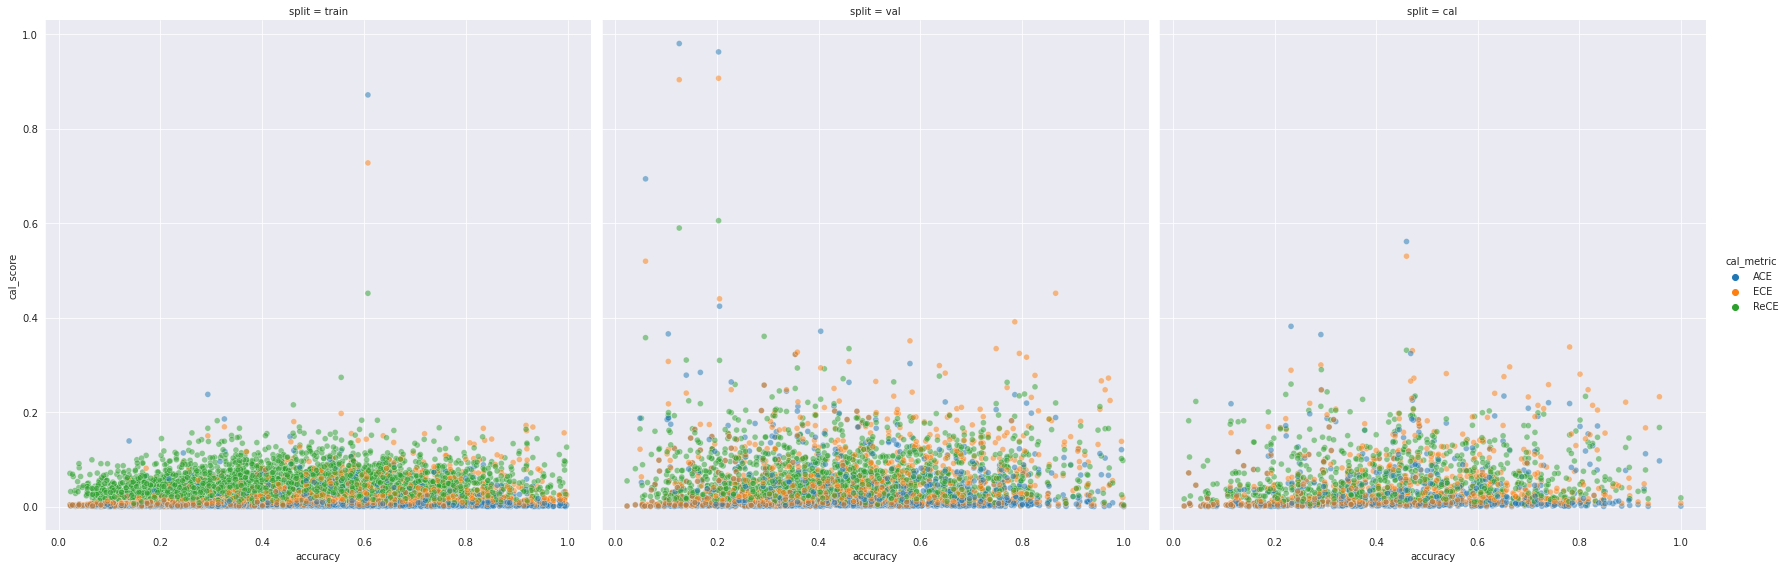

In [7]:
plt.rcParams.update({'font.size': 20})  

# for metric in ["ECE", "ReCE"]:
# data=all_logs[all_logs['cal_metric'] == metric],
g = sns.relplot(
    data=all_logs,
    x='accuracy',
    y='cal_score',
    col='split',
    hue='cal_metric',
    kind='scatter',
    height=8,
    facet_kws={"sharex": False},
    alpha=0.5,
    aspect=1
    )
# g.axes.flat[0].set_ylabel(metric)
plt.show()

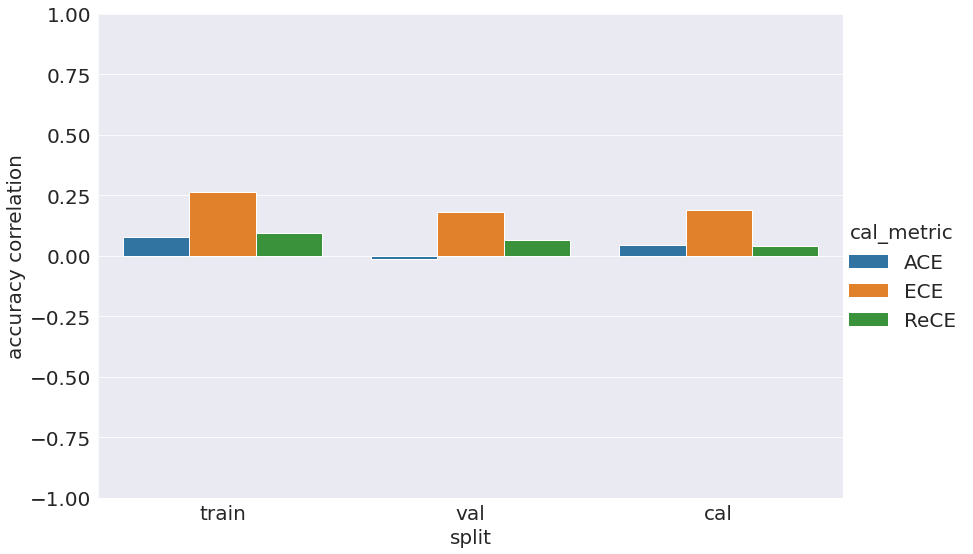

In [8]:
plt.rcParams.update({'font.size': 20})  

acc_corr = grouped_logs.apply(lambda x: x['accuracy'].corr(x['cal_score'])).reset_index(name='accuracy correlation')
acc_corr = reorder_splits(acc_corr)
g = sns.catplot(data=acc_corr, 
                x="split",
                y="accuracy correlation", 
                hue='cal_metric', 
                kind="bar", 
                height=8, 
                aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

## Correlation Comparison: Dice Score

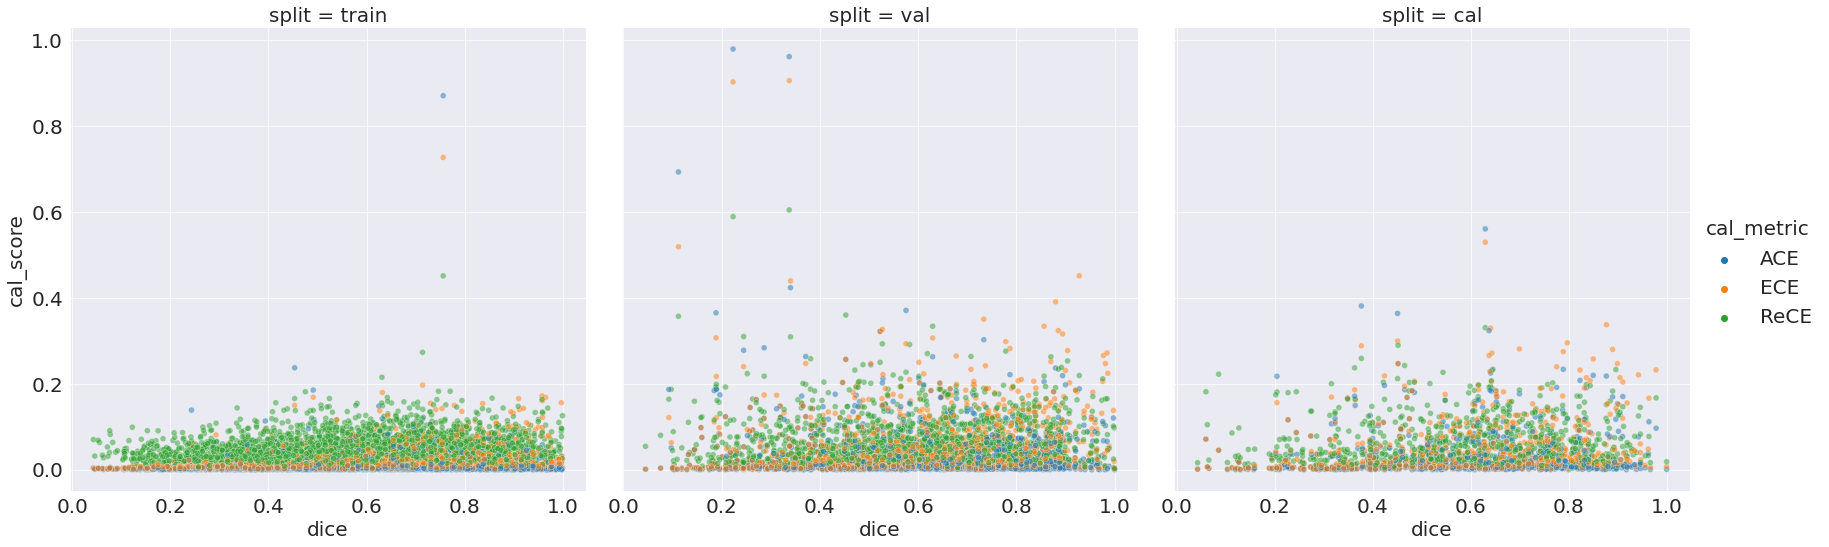

In [9]:
plt.rcParams.update({'font.size': 20})  

#for metric in ["ECE", "ReCE"]:
# data=all_logs[all_logs['cal_metric'] == metric],
g = sns.relplot(
    data=all_logs,
    x='dice',
    y='cal_score',
    col='split',
    hue='cal_metric',
    kind='scatter',
    height=8,
    facet_kws={"sharex": False},
    alpha=0.5,
    aspect=1
    )
# g.axes.flat[0].set_ylabel(metric)
plt.show()

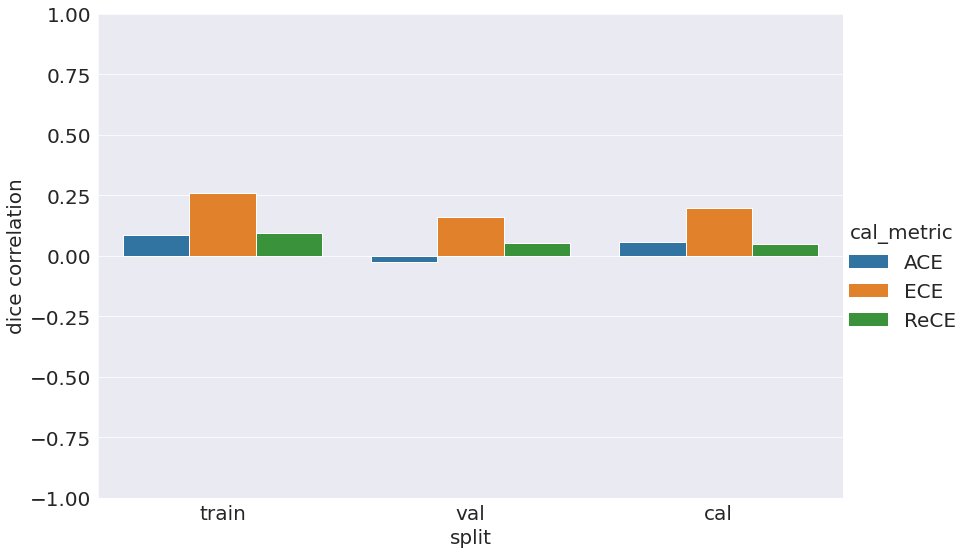

In [10]:
plt.rcParams.update({'font.size': 20})  

dice_correlations = grouped_logs.apply(lambda x: x['dice'].corr(x['cal_score'])).reset_index(name='dice correlation')
dice_correlations = reorder_splits(dice_correlations)
g = sns.catplot(data=dice_correlations, 
                x="split", 
                y="dice correlation", 
                hue='cal_metric', 
                kind="bar", 
                height=8, 
                aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))

## Correlation Comparison: Groundtruth Label Amount

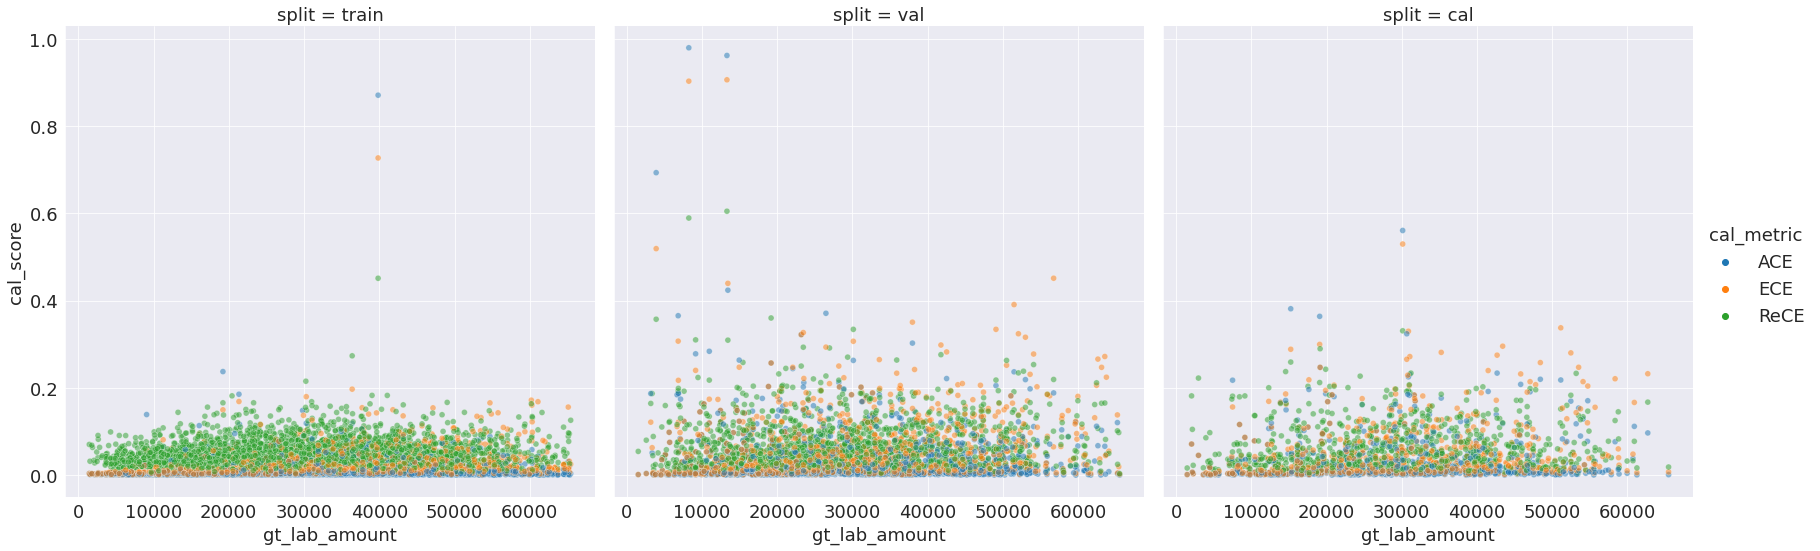

In [11]:
plt.rcParams.update({'font.size': 18})  

# for metric in ["ECE", "ReCE"]:
# data=all_logs[all_logs['cal_metric'] == metric],
g = sns.relplot(
    data=all_logs,
    x='gt_lab_amount',
    y='cal_score',
    hue='cal_metric',
    col='split',
    kind='scatter',
    height=8,
    facet_kws={"sharex": False},
    alpha=0.5,
    aspect=1)
# g.axes.flat[0].set_ylabel(metric)
plt.show()

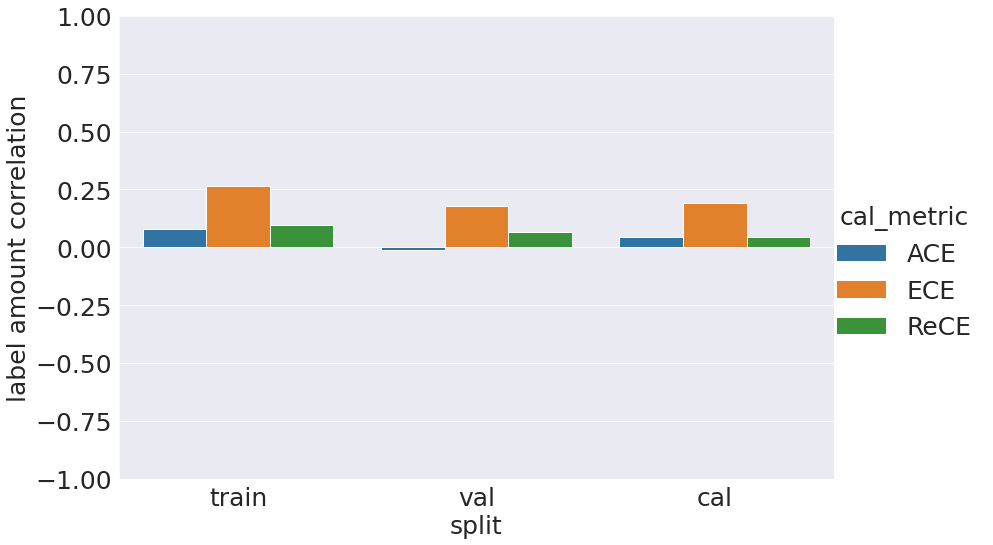

In [12]:
plt.rcParams.update({'font.size': 25})  

# Group by the three columns and apply correlation
label_amount_correlations = grouped_logs.apply(lambda x: x['gt_lab_amount'].corr(x['cal_score'])).reset_index(name='label amount correlation')
label_amount_correlations = reorder_splits(label_amount_correlations)
g = sns.catplot(data=label_amount_correlations, 
                x="split", 
                y="label amount correlation", 
                hue='cal_metric', 
                kind="bar", 
                height=8, 
                aspect=1.5)
# Set the y lim between - 1 and 1
g.set(ylim=(-1, 1))